## Improving Incident Identifcation and Resonse Time
There are limited security resources to monitor and respond to attacks on an increasing number of ephermal hosts and services. These hosts and services are now typically cloud based using the [DevOps model](https://en.wikipedia.org/wiki/DevOps) for deployment and management. This model makes identifying risk more difficult prior to service deployment and necessitates an automated solution to keep up with the environmental changes. 

"Time to compromise is almost always days or less, if not minues or less" - Verizon DBIR 2016


## Description of your data set and how it was obtained
* [Shodan](https://www.shodan.io/)
  * Public queries saved as CSV and downloaded
  * Data includes IP, domain and service details that are publicly searchable. Tool is commmonly used by attackers as part of the initial recon effort when defining a target. For example, what does the external presence of an organization include and what could be exploited
* [Public data on AS networks](https://en.wikipedia.org/wiki/Autonomous_system_(Internet)
 * Public data on which networks (ASN to IP address) are tied with any company or resource. Information is then fed into a tool like Shodan or uesd to execute new network scans, define targets, etc... Also assists in defining those networks that might be less protected
* Sanitized firewall data on network connections
  * Query by 'live' IP's collected in step one
  * Organized by GEO, Port dst, and frequency
  * Based on actual network/FW events showing traffic patterns
  
[Data repository on GitHub](https://github.com/dsarona/ds_class/tree/master/Project/data)

## Description of any pre-processing steps you took
* File Preparation
  * For Shodan data, execution of the right queries based on ASN followed by pulling down results in CSV. Because each ASN was its own report data combined into one CSV before import
* Data Review and Manipulation
  * Shodan Data
    * Slicing of banner field to create the Response column
       * shodan_complete['Response']=shodan_complete['Banner'].str.extract(r'(HTTP.\d.\d.\d\d\d)', expand=True)
    * Slicing of the host field to create the Domain column
    * Slicing of the banner field to create the webcode column
    * New columns based on 'webcode' and 'domain' - dummy values representing column entries
  * Firewall Data
    * By IP address all traffic for two 24 hour windows that matches the following:
        * Allow to DST IP at Adobe (based on live hosts from Shodan data)
        * Source from suspect GEO
        * Removal of outliers used for product activation
        * Anonymizing of all Russia/China/Iran/N.Korea traffic to 1 or 0 (1 = traffic present, 2 = nothing from that GEO)
* Data Import (grab from Shodan DF)
* Key fields to be used (y and x)
   * Targetted field for the Y, represents those IP's where FW traffic was allowed from Russia/China/Iran/N.Korea IP
   * X to be set with service type (production, dev or testing), service status (web response code), and which destination ports were used 

In [2]:
# access data using a relative path, Shodan only data currently
import pandas as pd
import re as r
import numpy as np
import matplotlib.pyplot as plt
shodan1 = pd.read_csv('./data/shodan_data_1313.csv', parse_dates=True)
shodan2 = pd.read_csv('./data/shodan_data_14365.csv', parse_dates=True)
shodan3 = pd.read_csv('./data/shodan_data_44786.csv', parse_dates=True)

In [3]:
frames = [shodan1, shodan2, shodan3]
shodan = pd.concat(frames)
shodan.shape

(348, 9)

In [4]:
fwdata = pd.read_excel(open('./data/GEO2_1.xls','rb'), sheetname='report')
fwdata.head(2)

,Destination IP,Targetted
0,216.104.209.254,Yes
1,216.104.209.253,Yes


In [6]:
#frames2 = [shodan, fwdata]
fwdata.rename(columns={'Destination IP':'IP'}, inplace=True)
shodan_complete = pd.merge(shodan, fwdata, how='outer')

In [7]:
pd.set_option('display.max_colwidth', -1)
shodan_complete.head(2)

,IP,Port,Banner,Timestamp,Hostnames,Country,City,Operating System,Organization,Targetted
0,192.150.16.10,4500.0,VPN (IKE NAT-T)\n\nInitiator SPI: e5f858a0876af576\nResponder SPI: 977987b5d8e61320\nNext Payload: Security Association (SA)\nVersion: 1.0\nExchange Type: Identity Protection\nFlags:\n Encryption: False\n Commit: False\n Authentication: False\nMessage ID: 00000000\nLength: 80,2016-11-03T04:05:11.336316,NaN,United States,NaN,NaN,Level 3 Communications,NaN
1,192.150.16.163,443.0,"HTTP/1.1 200 OK\r\nDate: Thu, 03 Nov 2016 03:55:51 GMT\r\nServer: Apache\r\nX-Adobe-Content: AEM,floodgate-pink\r\nX-Frame-Options: SAMEORIGIN\r\nVary: X-Adobe-SSL\r\nEdge-control: !no-store,max-age=15m\r\nAccept-Ranges: bytes\r\nCache-Control: max-age=900\r\nExpires: Thu, 03 Nov 2016 04:10:51 GMT\r\nX-dynaTrace: PT=13782565;PA=-1526674535;SP=prod;PS=170337423\r\nX-Adobe-Loc: da1\r\nTransfer-Encoding: chunked\r\nContent-Type: text/html; charset=UTF-8\r\n\r\n",2016-11-03T03:55:58.497287,192.150.16.163,United States,NaN,NaN,Level 3 Communications,NaN


## What you learned from exploring the data, including visualizations
* There is a significant number of external hosts available that don't appear to provide a business purpose. At least not one tied to the web ports open - no website running or providing a valid response
* The amount of 'suspect' traffic from certain GEO's was much larger than expected. Would appear that recon activity is nearly non-stop in some cases
* Some FW policy doesn't match expectations - allowed to IP's not currently in production

In [40]:
import numpy as np
shodan_complete['Response']=shodan_complete['Banner'].str.extract(r'(HTTP.\d.\d.\d\d\d)', expand=True)
shodan_complete['Response']=shodan_complete['Banner'].str.extract(r'(HTTP.\d.\d.\d\d\d)', expand=True)
shodan_complete['Webcode']=shodan_complete['Response'].str.extract(r'\s(\d\d\d)', expand=True)
shodan_complete['Domain']=shodan_complete['Hostnames'].str.extract(r'\.(.*?)\.com', expand=True)
shodan_complete.tail(4)

,IP,Port,Banner,Timestamp,Hostnames,Country,City,Operating System,Organization,Targetted,Response,Webcode,Domain,live,attacked,prod
1062,153.32.227.124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,0,1,0
1063,153.32.223.141,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,0,1,0
1064,153.32.221.153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,0,1,0
1065,153.32.221.147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,0,1,0


In [41]:
shodan_complete.head(2)

,IP,Port,Banner,Timestamp,Hostnames,Country,City,Operating System,Organization,Targetted,Response,Webcode,Domain,live,attacked,prod
0,192.150.16.10,4500.0,VPN (IKE NAT-T)\n\nInitiator SPI: e5f858a0876af576\nResponder SPI: 977987b5d8e61320\nNext Payload: Security Association (SA)\nVersion: 1.0\nExchange Type: Identity Protection\nFlags:\n Encryption: False\n Commit: False\n Authentication: False\nMessage ID: 00000000\nLength: 80,2016-11-03T04:05:11.336316,NaN,United States,NaN,NaN,Level 3 Communications,NaN,NaN,NaN,NaN,0,0,0
1,192.150.16.163,443.0,"HTTP/1.1 200 OK\r\nDate: Thu, 03 Nov 2016 03:55:51 GMT\r\nServer: Apache\r\nX-Adobe-Content: AEM,floodgate-pink\r\nX-Frame-Options: SAMEORIGIN\r\nVary: X-Adobe-SSL\r\nEdge-control: !no-store,max-age=15m\r\nAccept-Ranges: bytes\r\nCache-Control: max-age=900\r\nExpires: Thu, 03 Nov 2016 04:10:51 GMT\r\nX-dynaTrace: PT=13782565;PA=-1526674535;SP=prod;PS=170337423\r\nX-Adobe-Loc: da1\r\nTransfer-Encoding: chunked\r\nContent-Type: text/html; charset=UTF-8\r\n\r\n",2016-11-03T03:55:58.497287,192.150.16.163,United States,NaN,NaN,Level 3 Communications,NaN,HTTP/1.1 200,200,NaN,1,0,0


In [9]:
shodan_complete.Domain.value_counts()

adobe                     118
adobeitc                  49 
stage.adobe               16 
macromedia                3  
wip.adobe                 2  
adobedemo                 2  
rs.adobe                  2  
adobeprerelease           2  
day                       2  
licenses.adobe            2  
share.adobe               2  
dtm.adobeitc              1  
adobe-references          1  
cgi.adobe                 1  
digitalexperiencescore    1  
Name: Domain, dtype: int64

In [10]:
shodan_complete.Webcode.value_counts()

200    126
302    82 
404    32 
403    30 
301    12 
307    3  
503    3  
400    2  
401    2  
204    1  
500    1  
Name: Webcode, dtype: int64

In [11]:
# Create a new column called shodan_complete.live where the value is yes
# if shodan_complete.Response is response 200 and no if not
shodan_complete['live'] = np.where(shodan_complete['Webcode']=='200', '1', '0')

In [12]:
# Create a new column called shodan_complete.attacked where the value is yes
# if shodan_complete.Targetted is 'Yes' and no if not
shodan_complete['attacked'] = np.where(shodan_complete['Targetted']=='Yes', '1', '0')
shodan_complete.head(2)

,IP,Port,Banner,Timestamp,Hostnames,Country,City,Operating System,Organization,Targetted,Response,Webcode,Domain,live,attacked
0,192.150.16.10,4500.0,VPN (IKE NAT-T)\n\nInitiator SPI: e5f858a0876af576\nResponder SPI: 977987b5d8e61320\nNext Payload: Security Association (SA)\nVersion: 1.0\nExchange Type: Identity Protection\nFlags:\n Encryption: False\n Commit: False\n Authentication: False\nMessage ID: 00000000\nLength: 80,2016-11-03T04:05:11.336316,NaN,United States,NaN,NaN,Level 3 Communications,NaN,NaN,NaN,NaN,0,0
1,192.150.16.163,443.0,"HTTP/1.1 200 OK\r\nDate: Thu, 03 Nov 2016 03:55:51 GMT\r\nServer: Apache\r\nX-Adobe-Content: AEM,floodgate-pink\r\nX-Frame-Options: SAMEORIGIN\r\nVary: X-Adobe-SSL\r\nEdge-control: !no-store,max-age=15m\r\nAccept-Ranges: bytes\r\nCache-Control: max-age=900\r\nExpires: Thu, 03 Nov 2016 04:10:51 GMT\r\nX-dynaTrace: PT=13782565;PA=-1526674535;SP=prod;PS=170337423\r\nX-Adobe-Loc: da1\r\nTransfer-Encoding: chunked\r\nContent-Type: text/html; charset=UTF-8\r\n\r\n",2016-11-03T03:55:58.497287,192.150.16.163,United States,NaN,NaN,Level 3 Communications,NaN,HTTP/1.1 200,200,NaN,1,0


In [13]:
#sdtest=shodan_complete[['IP','prod','live','attacked']]
columns = ['IP', 'prod', 'live', 'attacked']
df1 = pd.DataFrame(shodan_complete, columns=columns)

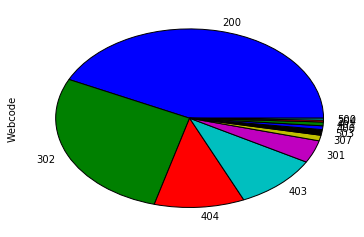

In [15]:
%matplotlib inline
shodan_complete.Webcode.value_counts().plot(kind='pie')

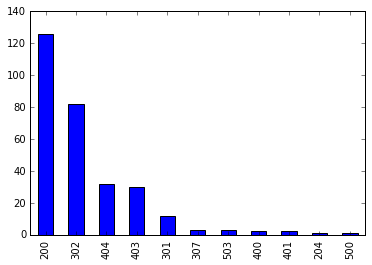

In [16]:
shodan_complete.Webcode.value_counts().plot(kind='bar')

## How you chose which features to use in your analysis
Looking for features that will help determine the following:
* Was the service or asset targeted based on service type
* Was the service or asset targeted based on web or service response
* Was the service or asset targeted based on domain details 

If any of these features indicate which hosts/services are to be targeted we can better define a review and mitigation strategy. 

## Details of your modeling process, including how you selected your models and validated them
Model Selected - http://scikit-learn.org/stable/modules/naive_bayes.html

Selection Process
* Review of data to be used - categorical and text predominately
* Data set size 

In [35]:
shodan_complete['prod'] = np.where(shodan_complete['Domain']=='adobe', '1', '0')

In [36]:
#sdtest=shodan_complete[['IP','prod','live','attacked']]
columns = ['IP', 'prod', 'live', 'attacked']
df1 = pd.DataFrame(shodan_complete, columns=columns)

In [37]:
# We have created our X (feature matrix) and Y (response vector so now lets:
# import our chosen estimator, instantiate it into a variable, fit the model with the X and y
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [38]:
# create X and y
feature_cols = ['prod', 'live']
X = df1[feature_cols]
y = df1.attacked

# instantiate and fit
linreg = LinearRegression()
linreg.fit(X, y)

# print the coefficients
print linreg.intercept_
print linreg.coef_

0.881791036122
[-0.56425755 -0.32068931]


In [39]:
df1.head()

,IP,prod,live,attacked
0,192.150.16.10,0,0,0
1,192.150.16.163,0,1,0
2,192.150.16.202,0,1,0
3,192.150.9.29,0,1,0
4,192.150.9.29,0,0,0


## Your challenges and successes
Challenges
* Data manipulation was required to get the features need for the modeling, more of an expected challenge
* Unexpected volume of traffic by GEO, when initially conceived didn't believe there would be so much interesting traffic orginating from the China and Russia GEO's
* Assumption of consistent FW policy became a real issue

Successes
* Ability to collect and summarize data by ASN - including services that are live, service responses, possible issues or vulnerabilities
* Actual identification of security issues based on initial analysis (identified vulnerable system configs)

## Conclusions and key learnings
* Data manipulation took much longer than expected
* Assumptions about FW data/policy proved problematic
* Ability to predict attacks/exploitation by defined attributes failed for the following:
  * Traffic is allowed for some VLAN's regardless of service status
  * All IP's are targetted at some level
  * Further review to also include traffic volumes might be requried
  
* Future attributes being reviewed
  * Flow data - amount of data in bytes
  * Session count for activity
  * Focusing on just web applications